# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [39]:
import json

# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_validate


%matplotlib inline

In [40]:
STATE = 42

In [41]:
# Сохранение результата для сравнения

results = {}


def model_save_results(
    model, X, y, model_name: str, folds: int = 5, poly="Нет", params=None
):

    cv_results = cross_validate(
        model,
        X,
        y,
        scoring="neg_mean_absolute_percentage_error",
        cv=folds,
        return_train_score=True,
    )
    train_score = -cv_results["train_score"].mean() * 100
    test_score = -cv_results["test_score"].mean() * 100

    print(f"MAPE on train: {train_score:.2f}%")
    print(f"MAPE on test: {test_score:.2f}%")

    results[model_name] = {
        "train_score": train_score,
        "test_score": test_score,
        "poly": poly,
        "params": json.dumps(params),
    }

Прочитаем исходные данные:

In [42]:
df = pd.read_csv("datasets/unconv.csv")
df.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [44]:
df.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


- Пропусков в данных нету
- Данные не стандартизированы, не масштабированы

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

<Axes: >

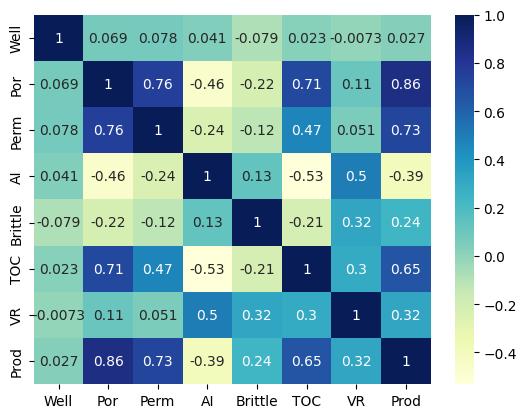

In [45]:
corr = df.corr()

sns.heatmap(corr, cmap="YlGnBu", annot=True)

<Axes: >

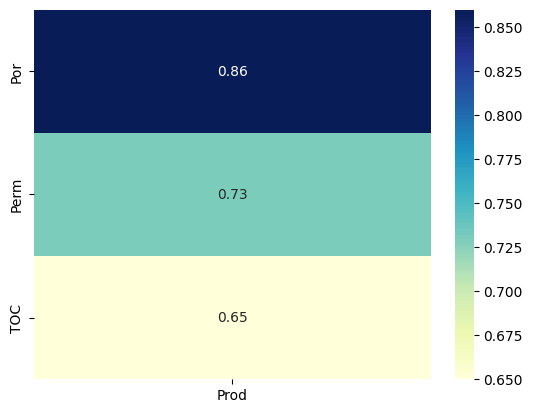

In [46]:
# Выделим 3 признака имеющих самую высокую корреляцию с целевым признаком Prod

top_3_feature_corr = (
    corr.abs().round(2).Prod.sort_values(ascending=False).head(4)[1:].to_frame()
)

sns.heatmap(top_3_feature_corr, cmap="YlGnBu", annot=True)

In [47]:
# Ранк матрицы
print(f"Ранк матрицы: {np.linalg.matrix_rank(corr)}")

Ранк матрицы: 8


In [48]:
# Детерминант матрицы
print(f"Детерминант матрицы: {np.linalg.det(corr):.>.4f}")

Детерминант матрицы: 0.0007


- Матрица близка к вырожденной, так как значение ее детерминанта достаточно мало. Соответственно данные являются плохо обусловленными. Хорошего решения классическим способом линеной регрессии, мы получить не сможем.

- Также мы имеем корелляцию между признаками и присутствует мультиколлинеарность.

- Применение метода МНК некоректно. Будем иметь большой bias.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [49]:
X = np.column_stack((np.ones(df.shape[0]), df.iloc[:, :7].values))
y = df.Prod

In [50]:
w_hat = np.linalg.inv(X.T @ X) @ X.T @ y

w_hat_df = pd.DataFrame(
    data=w_hat,
    index=np.hstack((["Intercept"], np.array(df.columns[:-1]))),
    columns=["k"],
)
mean_data = pd.concat(
    [pd.Series(data=[0], index=["Intercept"]), df.describe().loc["mean", :][:-1]]
)

w_hat_df = pd.concat([w_hat_df, mean_data], axis=1).rename(columns={0: "mean"})
w_hat_df["delta"] = w_hat_df.iloc[:, 0] * w_hat_df.iloc[:, 1]

w_hat_df_sorted = w_hat_df.sort_values(by=["delta"], ascending=False, key=abs)
w_hat_df_sorted["%"] = (
    w_hat_df_sorted.loc[:, "delta"] / w_hat_df_sorted.loc[:, "delta"].max() * 100
)

w_hat_df_sorted.style.format(
    {
        "k": "{:.0f}",
        "mean": "{:.2f}",
        "delta": "{:.2f}",
        "%": "{:.2f}",
    }
)

,k,mean,delta,%
Por,230,14.99,3450.65,100.00
VR,785,1.96,1542.49,44.70
Brittle,25,48.16,1203.78,34.89
AI,-365,2.97,-1084.23,-31.42
Perm,116,4.33,503.40,14.59
TOC,-78,0.99,-77.65,-2.25
Well,0,100.50,5.10,0.15
Intercept,-1232,0.00,-0.00,-0.00


- delta показывает, насколько каждый из признаков влияет на целевой признак.
- Well, TOC, Perm практически не влияет на результат;
- Por больше всего влияет на целевой признак;
- AI больше всего влияет в сторону уменьшения;

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [51]:
selected = np.hstack(([1], df.iloc[105].values[:-1]))
print(f"Предсказание при Well = 106: {(selected@w_hat):.0f}")

print(
    f"MAE при Well=106: {mean_absolute_error([df.iloc[105,-1]],[selected@w_hat]):.0f}"
)

predict_df = X @ w_hat

print(f"MAPE (общая): {mean_absolute_percentage_error(y,predict_df)*100:.2f}%")

Предсказание при Well = 106: 4723
MAE при Well=106: 25
MAPE (общая): 3.63%


- Обшика MAPE равна 3.6%
- Что, вероятно, является неплохим результатом. Но надо помнить, что еще не делали разбиение на train/test; Не ясно, как модель покажет себя на новых данных.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [52]:
pd.concat([corr.round(2).Prod[:-1], w_hat_df.iloc[:, 0]], axis=1).rename(
    columns={"Prod": "Кор. коэф"}
).style.format({"Кор. коэф": "{:.2f}", "Коэффициент": "{:.2f}"})

,Кор. коэф,k
Well,0.03,0.050700
Por,0.86,230.179140
Perm,0.73,116.239006
AI,-0.39,-365.202301
Brittle,0.24,24.994370
TOC,0.65,-78.400929
VR,0.32,785.259815
Intercept,nan,-1232.308030


- Векторы Toc и Prod сонаправлены, исходя из положительной корреляции между ними; Однако, коэффиценты идут со знаком -;

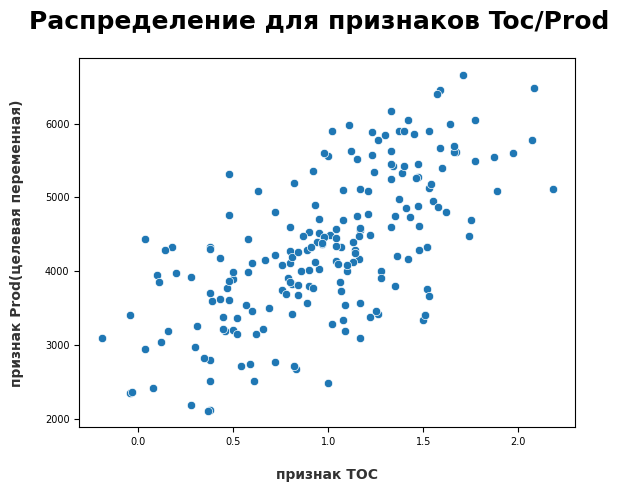

In [53]:
ax = sns.scatterplot(x="TOC", y="Prod", data=df)

plt.suptitle("Распределение для признаков Toc/Prod", size=18, weight=600)
ax.set_xlabel(
    "признак TOC",
    fontsize=10,
    labelpad=15,
    fontdict={"color": "#323232", "fontweight": 600},
)
ax.set_ylabel(
    "признак Prod(целевая переменная)",
    fontsize=10,
    labelpad=15,
    fontdict={"color": "#323232", "fontweight": 600},
)
ax.tick_params(axis="both", which="major", labelsize=7)

- Видно, что зависимость между признаками прямая и линейная, т.е с ростом одного признака, растет и другой.
- Отрицательный коэффицент обусловлен "плохой" моделью -- вызванной сильной мультиколлинеарности в данных, которая портит коэффициенты.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [54]:
mask = np.triu(np.ones_like(corr, dtype=bool))
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True]])

In [55]:
data_corr_masked = (
    corr[mask]
    .drop_duplicates()
    .unstack()
    .reset_index()[1:]
    .sort_values(by=0, ascending=False, key=abs)
    .rename(columns={0: "corr"})
)
data_corr_masked

,level_0,level_1,corr
63,Prod,Prod,1.000000
45,TOC,TOC,1.000000
36,Brittle,Brittle,1.000000
27,AI,AI,1.000000
9,Por,Por,1.000000
...,...,...,...
7,Well,Prod,0.026817
40,TOC,Well,0.022624
5,Well,TOC,0.022624
48,VR,Well,-0.007279


In [56]:
data_corr_masked_final = (
    data_corr_masked[abs(data_corr_masked["corr"]) > 0.7]
    .query("level_1 != 'Prod'")
    .query("level_1 != level_0")
)
data_corr_masked_final

,level_0,level_1,corr
57,Prod,Por,0.861910
17,Perm,Por,0.760546
10,Por,Perm,0.760546
58,Prod,Perm,0.727426
41,TOC,Por,0.711831
13,Por,TOC,0.711831


In [57]:
corr_features = set(data_corr_masked_final.iloc[:, :2].stack().values)
corr_features.discard("Prod")
corr_features = list(corr_features)

In [58]:
pd.DataFrame(
    data=[
        corr.loc["Prod", corr_features[idx]].round(2)
        for idx, feature in enumerate(corr_features)
    ],
    columns=["Коэф Кореляции с целевым признаком"],
    index=corr_features,
).sort_values(by="Коэф Кореляции с целевым признаком", ascending=False)

,Коэф Кореляции с целевым признаком
Por,0.86
Perm,0.73
TOC,0.65


- Удалим признаки, где корреляция между собой выше 0.7 и ниже 0.05 
- Удаляем признаки Perm, Toc и Well

In [59]:
X_new = np.column_stack(
    (
        np.ones(df.shape[0]),
        pd.concat([df.iloc[:, 1:2], df.iloc[:, 3:5], df.iloc[:, 6]], axis=1).values,
    )
)
y = df.Prod

In [60]:
# вычислим OLS-оценку для коэффициентов
w_hat_new = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y

w_hat_df_new = pd.DataFrame(
    data=w_hat_new,
    index=np.hstack(
        (
            ["Intercept"],
            np.hstack([df.columns[1], df.columns[3:5], df.columns[6]]),
        )
    ),
    columns=["Коэффициент"],
)
w_hat_df_new.round()

,Коэффициент
Intercept,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


In [61]:
predict_df_new = X_new @ w_hat_new

print(f"MAPE: {mean_absolute_percentage_error(y,predict_df_new)*100:.2f}")

pd.concat([corr.round(2).Prod[[1, 3, 4, 6]], w_hat_df_new[1:]], axis=1).rename(
    columns={"Prod": "Кор. коэф"}
)

MAPE: 4.04


/tmp/ipykernel_698/731541443.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.concat([corr.round(2).Prod[[1, 3, 4, 6]], w_hat_df_new[1:]], axis=1).rename(


,Кор. коэф,Коэффициент
Por,0.86,293.036246
AI,-0.39,-200.030912
Brittle,0.24,27.640982
VR,0.32,517.402726


- Ушла проблема, когда при увеличении значения мы получали уменьшение целевого параметра, при ожидаемом увеличении;
- Ухудшилась метрика; Но т.к. не делалось разбиений на train/test или фолдов, сложно говорить, не переобучалась ли модель;

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [62]:
model = LinearRegression(fit_intercept=False)

model.fit(X_new, y)

w_coeff_df_lr = pd.DataFrame(
    data=model.coef_,
    index=np.hstack(
        (
            ["Intercept"],
            np.hstack([df.columns[1], df.columns[3:5], df.columns[6]]),
        )
    ),
    columns=["Коэффициент"],
)
display(w_coeff_df_lr.round())

predict_df_new_lr = model.predict(X_new)

print(f"MAPE: {mean_absolute_percentage_error(y,predict_df_new)*100:.2f}")

,Коэффициент
Intercept,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


MAPE: 4.04


In [63]:
model_save_results(model, X_new, y, model_name="LinearRegression")

MAPE on train: 4.02%
MAPE on test: 4.23%


- Результаты модели LinearRegression из библиотеки sklearn, идентичны значениям коэффициентов, полученных нами путем путем применения матричной формулы;


## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [64]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [65]:
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_new[:, 1:])

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_transformed = poly.fit_transform(X_poly)

lr = LinearRegression()

model_save_results(
    lr,
    X_poly_transformed,
    y,
    model_name="LinearRegression_PolynomialFeatures",
    poly="Да",
)

MAPE on train: 1.77%
MAPE on test: 2.68%


- Добавление полиномиальных фичей позволило снизить bias линейной модели.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [66]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param = {"alpha": [0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20, 100]}

lasso = Lasso()

grid_serach = GridSearchCV(
    scoring="neg_mean_absolute_percentage_error",
    estimator=lasso,
    param_grid=param,
    cv=5,
    n_jobs=-1,
)

grid_serach.fit(X_poly_transformed, y)
grid_serach.best_params_

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+04, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+04, tolerance: 1.617e

{'alpha': 5}

In [67]:
model_save_results(
    Lasso(alpha=5),
    X_poly_transformed,
    y,
    model_name="LinearRegression_PolynomialFeatures_Lasso",
    poly="Да",
    params={"alpha": 5},
)

MAPE on train: 1.83%
MAPE on test: 2.28%


Была построена модель линейной регрессией с регуляризацией L1-Lasso.



### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [68]:
from sklearn.linear_model import Ridge

param = {"alpha": [0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20, 100]}

ridge = Ridge()

grid_serach = GridSearchCV(
    scoring="neg_mean_absolute_percentage_error",
    estimator=ridge,
    param_grid=param,
    cv=5,
    n_jobs=-1,
)

grid_serach.fit(X_poly_transformed, y)

print(grid_serach.best_params_)

{'alpha': 0.2}


In [69]:
model_save_results(
    Ridge(alpha=0.2),
    X_poly_transformed,
    y,
    model_name="LinearRegression_PolynomialFeatures_Ridge",
    poly="Да",
    params={"alpha": 0.2},
)

MAPE on train: 1.77%
MAPE on test: 2.67%


Была построена модель линейной регрессией с регуляризацией L2-Ridge.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [70]:
from sklearn.linear_model import ElasticNet

param = {
    "alpha": [0.01, 0.05, 0.1, 0.2, 0.3, 1, 1.5, 2, 3, 4, 5],
    "l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
}

e_net = ElasticNet()

grid_serach = GridSearchCV(
    scoring="neg_mean_absolute_percentage_error",
    estimator=e_net,
    param_grid=param,
    cv=5,
    n_jobs=-1,
)

grid_serach.fit(X_poly_transformed, y)

print(grid_serach.best_params_)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.948e+04, tolerance: 1.582e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+06, tolerance: 1.545e

{'alpha': 5, 'l1_ratio': 1}


In [71]:
model_save_results(
    ElasticNet(alpha=5, l1_ratio=1),
    X_poly_transformed,
    y,
    model_name="LinearRegression_PolynomialFeatures_ElasticNet",
    poly="Да",
    params={"alpha": 5, "l1_ratio": 1},
)

MAPE on train: 1.83%
MAPE on test: 2.28%


- Представлена ElasticNet регуляризация;
- Результат, впрочем, совпал с l1;

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [72]:
results

{'LinearRegression': {'train_score': 4.021160454375212,
  'test_score': 4.231002704164561,
  'poly': 'Нет',
  'params': 'null'},
 'LinearRegression_PolynomialFeatures': {'train_score': 1.7732404749972865,
  'test_score': 2.6808754502486583,
  'poly': 'Да',
  'params': 'null'},
 'LinearRegression_PolynomialFeatures_Lasso': {'train_score': 1.827930571951013,
  'test_score': 2.276158066543644,
  'poly': 'Да',
  'params': '{"alpha": 5}'},
 'LinearRegression_PolynomialFeatures_Ridge': {'train_score': 1.7739393193862962,
  'test_score': 2.672457369619562,
  'poly': 'Да',
  'params': '{"alpha": 0.2}'},
 'LinearRegression_PolynomialFeatures_ElasticNet': {'train_score': 1.827930571951013,
  'test_score': 2.276158066543644,
  'poly': 'Да',
  'params': '{"alpha": 5, "l1_ratio": 1}'}}

In [74]:
result_df = pd.DataFrame(results).T.sort_values(
    by=["test_score", "train_score"], ascending=True
)
result_df[["train_score", "test_score"]] = result_df[
    ["train_score", "test_score"]
].astype("float64")
result_df["delta"] = result_df["test_score"] - result_df["train_score"]

result_df = result_df[["train_score", "test_score", "delta", "poly", "params"]]

result_df

,train_score,test_score,delta,poly,params
LinearRegression_PolynomialFeatures_Lasso,1.827931,2.276158,0.448227,Да,"{""alpha"": 5}"
LinearRegression_PolynomialFeatures_ElasticNet,1.827931,2.276158,0.448227,Да,"{""alpha"": 5, ""l1_ratio"": 1}"
LinearRegression_PolynomialFeatures_Ridge,1.773939,2.672457,0.898518,Да,"{""alpha"": 0.2}"
LinearRegression_PolynomialFeatures,1.773240,2.680875,0.907635,Да,null
LinearRegression,4.021160,4.231003,0.209842,Нет,null


В процессе исследования были построены модели на основе Линейной регрессии.

- Модель без полиномиальных признаков, имеет самые худшие показатели предсказания;
- Модель с регуляризации L2, хотя и показала результат лучше, чем LR без добавления полиномиальных признаков, построенная на тех же полиномиальных признаках, сильно проиграла L1 регуляризации;
- Алгоритм оптимизации подобрал l1_ratio, фактически приравняв ElasticNet к L1;

- Показали, что в данном случае, применение полиномиальных признаков сильно улучшают предсказательную способность линейной модели;
- Наилучший результат L1 регуляризация на полиномиальных признаках 3 степени;